In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import texthero as hero
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
df_rotulados = pd.read_csv('dados/df_rotulados_spel_diac.csv', sep='|')
df_rotulados.drop(['LABELS'], axis=1, inplace=True)
print(df_rotulados.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ID       330 non-null    object
 1   DECISAO  330 non-null    object
 2   1        330 non-null    int64 
 3   2        330 non-null    int64 
 4   3        330 non-null    int64 
 5   4        330 non-null    int64 
 6   5        330 non-null    int64 
 7   6        330 non-null    int64 
 8   7        330 non-null    int64 
 9   8        330 non-null    int64 
 10  9        330 non-null    int64 
 11  10       330 non-null    int64 
 12  11       330 non-null    int64 
dtypes: int64(11), object(2)
memory usage: 33.6+ KB
None


In [3]:
def acordoas_categoria(title=''):

    categories = list(df_rotulados.columns.values)
    sns.set(font_scale = 2)
    plt.figure(figsize=(15,8))

    ax= sns.barplot(categories[2:], df_rotulados.iloc[:,2:].sum().values)
    plt.title(title, fontsize=24)
    plt.ylabel('Numero de acórdãos', fontsize=18)
    plt.xlabel('Tipo de acórdão ', fontsize=18)
    
    #adding the text labels
    rects = ax.patches
    labels = df_rotulados.iloc[:,2:].sum().values
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height + 1, label, ha='center', va='bottom', fontsize=14)
    plt.show()
    

def max_len(x):
    return len(x.split())

/home/modanez/anaconda3/envs/servio/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


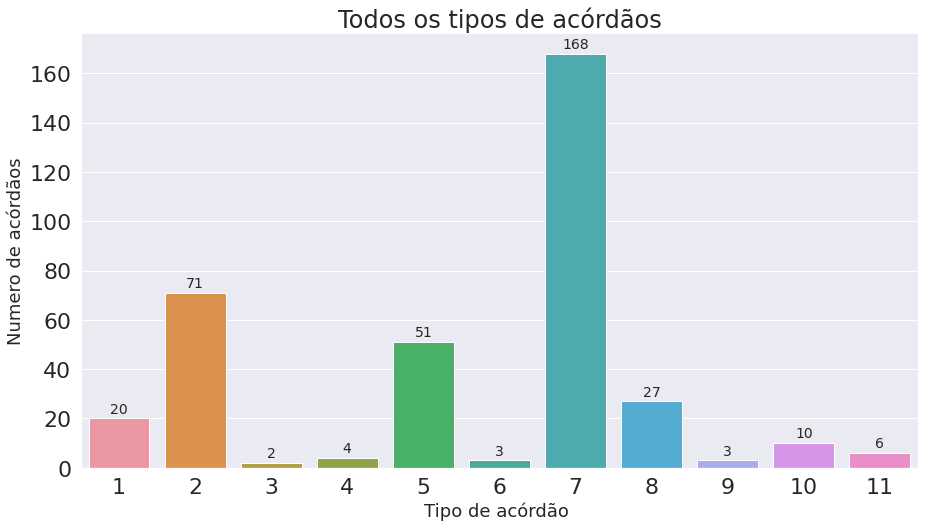

/home/modanez/anaconda3/envs/servio/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


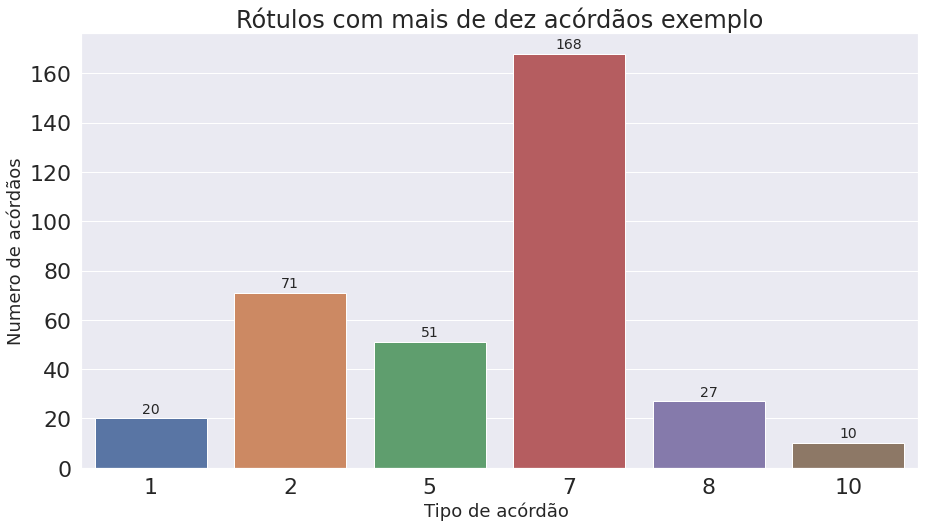

In [4]:
acordoas_categoria('Todos os tipos de acórdãos')

''' Remoção das classes com menos de 10 exemplos uma vez que isso interfere na hora de calcular a curva ROC, 
pois no momento do split dos dados para criação dos dataset de treino e teste não há registros suficientes para todas as classes
'''
df_rotulados.drop(['3','4','6','9', '11'],axis=1, inplace=True)

# Remoção das linhas que pelo motivo acima não possuem registros
df_rotulados.drop(df_rotulados.loc[(df_rotulados.iloc[:,2:].sum(axis=1))==0].index, axis=0, inplace=True)

acordoas_categoria('Rótulos com mais de dez acórdãos exemplo')

/home/modanez/anaconda3/envs/servio/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


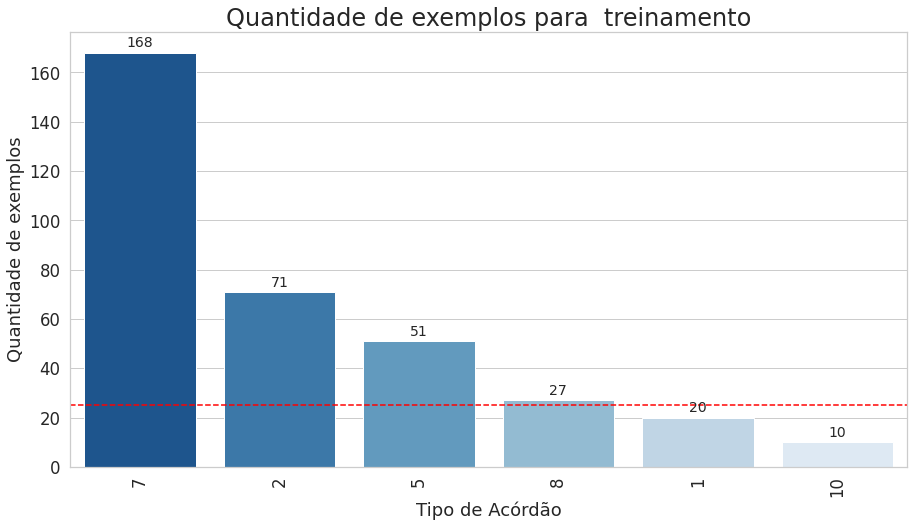

In [5]:
bar_plot = pd.DataFrame()
bar_plot['ACORDAOS'] = df_rotulados.columns[2:]
bar_plot['SOMA'] = df_rotulados.iloc[:,2:].sum().values
bar_plot.sort_values(['SOMA'], inplace=True, ascending=False)
bar_plot.reset_index(inplace=True, drop=True)
# print(bar_plot)

threshold = 25

plt.figure(figsize=(15,8))
sns.set(font_scale = 1.5)
sns.set_style('whitegrid') 


pal = sns.color_palette("Blues_r", len(bar_plot))
rank = bar_plot['SOMA'].argsort().argsort()  

ax = sns.barplot(bar_plot['ACORDAOS'], bar_plot['SOMA'], palette=np.array(pal[::-1])[rank])
plt.axhline(threshold, ls='--', c='red')
plt.title("Quantidade de exemplos para  treinamento", fontsize=24)
plt.ylabel('Quantidade de exemplos', fontsize=18)
plt.xlabel('Tipo de Acórdão', fontsize=18)
plt.xticks(rotation='vertical')

# adding the text labels
rects = ax.patches
labels = bar_plot.SOMA
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 1, label, ha='center', va='bottom', fontsize=14)
plt.show()

In [6]:
bar_plot = pd.DataFrame()
bar_plot['ACORDAOS'] = df_rotulados.columns[2:]
bar_plot['SOMA'] = df_rotulados.iloc[:,2:].sum().values
bar_plot.sort_values(['SOMA'], inplace=True, ascending=False)
bar_plot.reset_index(inplace=True, drop=True)
# print(bar_plot)

In [7]:
columns=['DNN', 'CNN', 'RNN', 'LSTM']
results = pd.DataFrame(columns = columns)
results

,DNN,CNN,RNN,LSTM


# **Deep Learning**

## **DNN**

In [8]:
tokenizer = Tokenizer(num_words=5000, lower=True)
tokenizer.fit_on_texts(df_rotulados.DECISAO)
sequences = tokenizer.texts_to_sequences(df_rotulados.DECISAO)
x = pad_sequences(sequences, maxlen=200)

seeds = [1, 43, 678, 90, 135, 77]

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    df_rotulados[df_rotulados.columns[3:]], 
                                                    test_size=0.3, 
                                                    random_state=seeds[4])

In [10]:
bar_plot['PESO'] = len(bar_plot) / bar_plot['SOMA']
class_weight = {}
categories = df_rotulados.columns[2:]
for index, label in enumerate(categories):
    class_weight[index] = bar_plot[bar_plot['ACORDAOS'] == categories]['PESO'].values[0]
    
# bar_plot

In [11]:
num_classes = y_train.shape[1]
max_words = len(tokenizer.word_index) + 1
# maxlen = 256
maxlen = max(df_rotulados.DECISAO.apply(max_len))

In [12]:
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [13]:
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalMaxPool1D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard
import tensorflow as tf

model = Sequential()
model.add(Embedding(max_words, 20, input_length=maxlen))
model.add(Dropout(0.2))
model.add(GlobalMaxPool1D())
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(optimizer=Adam(0.015), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
callbacks = [
    ReduceLROnPlateau(),
    EarlyStopping(patience=10),
    TensorBoard('./logs/dnn'),
    ModelCheckpoint(filepath='./weights/dnn/model_dnn_reg_diac.h5', save_best_only=True)
]


history = model.fit(x_train, y_train,
                    class_weight=class_weight,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.4,
                    callbacks=callbacks)

In [14]:
cnn_model = model
metrics = cnn_model.evaluate(x_test, y_test)
print("{}: {}".format(cnn_model.metrics_names[1], metrics[1]))

In [15]:
results.loc[4,'DNN'] = metrics[1]
results

## **CNN**

In [17]:
from tensorflow.keras.layers import Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, Dropout, Conv1D

filter_length = 300

model = Sequential()
model.add(Embedding(max_words, 20, input_length=maxlen))
model.add(Dropout(0.2))
model.add(Conv1D(filter_length, 3, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPool1D())
model.add(Dense(num_classes))
model.add(Activation('sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

callbacks = [
    ReduceLROnPlateau(),
    EarlyStopping(patience=10),
    TensorBoard('./logs/cnn'),
    ModelCheckpoint(filepath='./weights/cnn/model_cnn_reg_diact.h5', save_best_only=True)
]

history = model.fit(x_train, y_train,
                    class_weight=class_weight,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.4,
                    callbacks=callbacks,
                    verbose = 0)

Instructions for updating:
use `tf.profiler.experimental.stop` instead.


In [18]:
cnn_model = model
metrics = cnn_model.evaluate(x_test, y_test)
print("{}: {}".format(model.metrics_names[1], metrics[1]))

3/3 [==============================] - 0s 4ms/step - loss: 0.3868 - auc: 0.8309
auc: 0.830941915512085


In [19]:
results.loc[4,'CNN'] = metrics[1]
results

,DNN,CNN,RNN,LSTM
4,NaN,0.830942,NaN,NaN


In [20]:
df_acordaos = pd.read_csv('dados/df_acordaos_mini.csv', sep='|')

In [21]:
start_time = datetime.now()
df_acordaos.DECISAO = hero.remove_diacritics(df_acordaos.DECISAO)
print('Duration: {}'.format(datetime.now() - start_time))

Duration: 0:00:00.007977


In [23]:
# tokenizer = Tokenizer(num_words=5000, lower=True)

start_time = datetime.now()
tokenizer.fit_on_texts(df_acordaos.DECISAO)
print('Duration: {}'.format(datetime.now() - start_time))

start_time = datetime.now()
sequences = tokenizer.texts_to_sequences(df_acordaos.DECISAO)
print('Duration: {}'.format(datetime.now() - start_time))

start_time = datetime.now()
x = pad_sequences(sequences, maxlen=maxlen)
print('Duration: {}'.format(datetime.now() - start_time))

Duration: 0:00:02.437174
Duration: 0:00:01.509903
Duration: 0:00:01.057764


In [ ]:
def create_output(predictions):
    probabilities = []
    for (i, prediction) in enumerate(predictions):
        preds = prediction["probabilities"]
        probabilities.append(preds)
    dff = pd.DataFrame(probabilities)
    dff.columns = LABEL_COLUMNS
    
    return dff

In [54]:
saida = cnn_model.predict(x)
saida
# predicted_labels = [int(round(x[0])) for x in saida]
# for input, label in zip(df_temp.ID, predicted_labels):
#   print("Question: ", input)
#   print("Predicted label: ", label)

array([[0.2945013 , 0.1855956 , 0.5274114 , 0.10406723, 0.04058983],
       [0.2591218 , 0.15977886, 0.5505579 , 0.0824104 , 0.02918528],
       [0.32218474, 0.21807194, 0.5233577 , 0.14590986, 0.06779421],
       ...,
       [0.28923365, 0.19282818, 0.54215723, 0.12243419, 0.05137949],
       [0.2746857 , 0.17946811, 0.5549184 , 0.10023239, 0.04138221],
       [0.30764017, 0.19761239, 0.51258266, 0.11948653, 0.05241476]],
      dtype=float32)

## **GLOVE - LSTM**

In [24]:
from gensim.models import KeyedVectors

In [75]:
embedding = KeyedVectors.load_word2vec_format('embedding/nilc/glove_s50.txt', encoding='utf8')

NUM_WORDS = 32148
EMBEDDING_DIM=embedding.vector_size
word_index = tokenizer.word_index
vocabulary_size=min(len(word_index)+1,NUM_WORDS)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in word_index.items():
    if i>=NUM_WORDS:
        continue
    try:
        embedding_vector = embedding[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

In [86]:
from tensorflow.keras.layers import Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, Dropout, Conv1D, LSTM

model = Sequential()
model.add(Embedding(vocabulary_size, EMBEDDING_DIM, weights=[embedding_matrix], trainable=False))
# model.add(Embedding(max_words, 20, input_length=maxlen))
model.add(LSTM(128))
model.add(Dropout(0.3))
model.add(Dense(num_classes))
model.add(Activation('sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

callbacks = [
    ReduceLROnPlateau(),
    EarlyStopping(patience=10),
    TensorBoard('./logs/lstm'),
    ModelCheckpoint(filepath='./weights/cnn/model_lstm_reg_diact.h5', save_best_only=True)
]

# model.summary()

history = model.fit(x_train, y_train,
                    class_weight=class_weight,
                    epochs=30,
                    batch_size=32,
                    validation_split=0.4,
                    callbacks=callbacks,
                    verbose = 0)

In [87]:
lstm_model = model
metrics = lstm_model.evaluate(x_test, y_test)
print("{}: {}".format(model.metrics_names[1], metrics[1]))

3/3 [==============================] - 0s 4ms/step - loss: 0.3922 - auc_27: 0.8142
auc_27: 0.8142105937004089


In [55]:
results.loc[4,'LSTM'] = metrics[1]
results

,DNN,CNN,RNN,LSTM
4,NaN,0.830942,NaN,0.814238


In [88]:
saida = lstm_model.predict(x)
saida

array([[0.2155244 , 0.10974295, 0.41819125, 0.07940193, 0.02606746],
       [0.19284432, 0.16528007, 0.4549945 , 0.10862453, 0.05980076],
       [0.38152906, 0.09324058, 0.4537755 , 0.04956594, 0.01125131],
       ...,
       [0.10942209, 0.2273188 , 0.47306922, 0.1374574 , 0.03095286],
       [0.26444358, 0.23311444, 0.5242134 , 0.11098853, 0.03258627],
       [0.22102538, 0.21411033, 0.3863691 , 0.1247294 , 0.06058919]],
      dtype=float32)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

In [ ]:
tf.keras.utils.plot_model(dnn-model)
tf.keras.utils.plot_model(cnn-model)
tf.keras.utils.plot_model(lstm-model)

In [ ]:
import matplotlib.pyplot as plt

acc = history_dict['auc_1']
val_acc = history_dict['val_auc_1']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Loss de Treinamento')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Loss de Validação')
plt.title('Loss do Treinamento e da Validação')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Acurácia do Treinamento')
plt.plot(epochs, val_acc, 'b', label='Acurácia da Validação')
plt.title('Acurácia do Treino e da Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

plt.show()